## Baseline Model : Simple Regression

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import info, split_train_and_test_period

### 데이터 로드 & 전처리
- 02_preprocess에서 최종적으로 정의한 Query 사용

In [11]:
%%time
base_query = """
WITH base_data AS 
(
    SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
    FROM (
        SELECT *
        FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
        WHERE 
            EXTRACT(MONTH from pickup_datetime) = 1
            and pickup_latitude  <= 90 and pickup_latitude >= -90
        ) AS nyc_taxi
    JOIN (
        SELECT zip_code, state_code, state_name, city, county, zip_code_geom
        FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
        WHERE state_code='NY'
        ) AS gis 
    ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT
    zip_code,
    pickup_hour,
    EXTRACT(MONTH FROM pickup_hour) AS month,
    EXTRACT(DAY FROM pickup_hour) AS day,
    CAST(format_datetime('%u', pickup_hour) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_hour) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    cnt
FROM (
    SELECT 
        DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
        count(*) AS cnt,
        zip_code
    FROM base_data
    GROUP BY pickup_hour, zip_code
)
ORDER BY pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=info['project'])

CPU times: user 1.2 s, sys: 48.1 ms, total: 1.24 s
Wall time: 7.25 s


#### Target 분포 파악
- 왼쪽으로 심하게 몰린 비대칭적인 분포를 띄기에 log를 적용해 Normalization

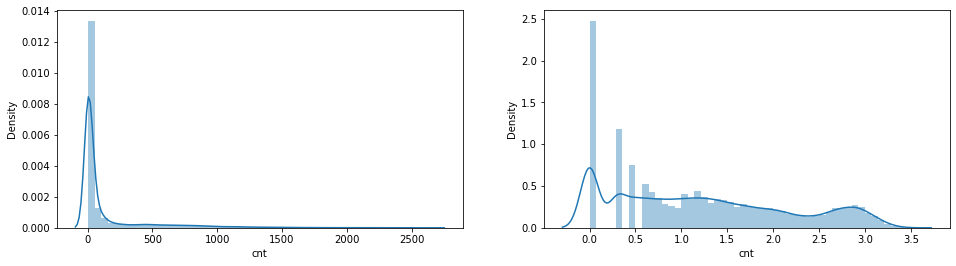

In [12]:
plt.figure(figsize=(16, 4))

# raw_cnt 분포
plt.subplot(121)
sns.distplot(base_df['cnt']);

# Log Scaling cnt 분포
plt.subplot(122)
sns.distplot(np.log10(base_df['cnt']));

In [13]:
# log_cnt 생성
base_df['log_cnt'] = np.log10(base_df['cnt'])

### Train / Test Split

In [14]:
train_df, test_df = split_train_and_test_period(base_df, 7)

In [15]:
def split_x_and_y_log(train_df, test_df, y):
    train_df.drop(columns=['zip_code', 'pickup_hour'], inplace=True)
    test_df.drop(columns=['zip_code', 'pickup_hour'], inplace=True)
    
    y_train_raw = train_df.pop('cnt')
    y_train_log = train_df.pop(y)
    y_test_raw = test_df.pop('cnt')
    y_test_log = test_df.pop(y)
    
    x_train = train_df.copy()
    x_test = test_df.copy()
    
    return x_train, x_test, y_train_log, y_test_raw, y_test_log

In [17]:
x_train, x_test, y_train_log, y_test_raw, y_test_log = split_x_and_y_log(train_df, test_df, y='log_cnt')

### Simple Regression (One-Hot Encoding X)

In [18]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [19]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)

test_df['pred_log']= pred
test_df['pred_reverse'] = 10**pred

test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

In [20]:
# 실제값과 로그변환을 한 예측값 비교
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,464.222737,131.703921,103723.801952


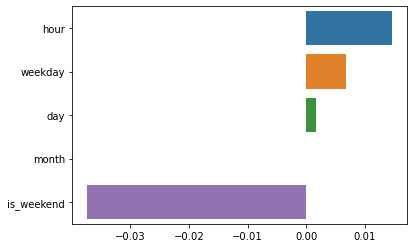

In [21]:
# Feature Importance
coef = pd.Series(lr_reg.coef_ , index=x_train.columns).sort_values(ascending=False)
sns.barplot(x=coef.values , y=coef.index);

### Simple Regression (One Hot Encoding 적용)

In [22]:
enc = OneHotEncoder(handle_unknown='ignore')

ohe_output = enc.fit_transform(base_df[['zip_code']]).toarray()
ohe_df = pd.concat([base_df, pd.DataFrame(ohe_output, columns='zip_code_'+ enc.categories_[0])], axis=1)

ohe_df.head(2)

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt,zip_code_10001,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
0,10075,2015-01-01,1,1,3,0,0,444,2.647383,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11201,2015-01-01,1,1,3,0,0,169,2.227887,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
ohe_df['log_cnt'] = np.log10(ohe_df['cnt'])
train_df, test_df = split_train_and_test_period(ohe_df, 7)

x_train, x_test, y_train_log, y_test_raw, y_test_log = split_x_and_y_log(train_df, test_df, y='log_cnt')

In [24]:
lr_reg_2 = LinearRegression()
lr_reg_2.fit(x_train, y_train_log)
pred_2 = lr_reg_2.predict(x_test)

test_df['pred_log']= pred_2
test_df['pred_reverse'] = 10**pred_2
test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

# inf를 제외하기 위한 전처리
test_df = test_df[np.isfinite(test_df).all(1)]

In [26]:
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,244.94387,67.00893,27045.484961


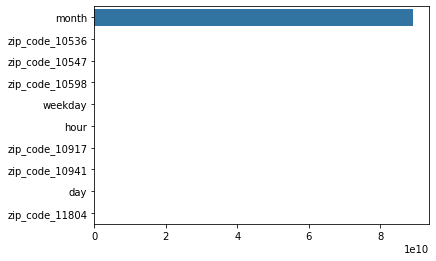

In [27]:
coef = pd.Series(lr_reg_2.coef_ , index=x_train.columns).sort_values(ascending=False)[:10]
sns.barplot(x=coef.values , y=coef.index);

---

---

## Baseline Result
- Target 분포 : 비대칭도가 심하게 왼쪽으로 기울어져 있기 때문에 Log Scaling을 적용한 데이터셋의 성능이 더 좋을 것이라고 판단.
- Baseline Simple Regression
    - One-Hot Encoding X
        - MSE : 103723, 시간과 요일에 대한 Feature의 중요도가 높다는 것을 알 수 있다.
    - One-Hot Encoding O
        - MSE : 27045, 해석적으로 접근하기에 불가능하다는 것을 알 수 있다.
            - Feature Importance를 봤을 때, 영향력 있는 특정 zip_code가 없다는 것을 알 수 있다. 그렇기에 전처리는 하되, 차원을 줄이는 방향으로 결정
        
### 모델링 진행방향

```
성능적인 측면에서 첫번째 모델보다 성능이 좋아졌지만 해석적인 측면에서는 좋지 않은 모델이라고 할 수 있다.

해당 프로젝트에 관점에 대한 중요도 순은 모델성능 > 해석가능성 및 Inference 이기에, 
모델의 성능은 최대한 높이면서 부가적으로 Inference를 할 수 있도록 모델링하는 것으로 결정

1. Encoder를 One-Hot Encoder에서 Label Encoder로 변경하여 범주형 전처리 진행 >> 차원을 줄이고, 결과 해석을 높이기 위해
2. 다양한 Ensemble 모델링을 통해 가장 높은 성능을 가진 모델 선정
3. 추가적인 Feature Engineering을 통해 모델의 성능 향상
```